In [21]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.xinwei_fdnc.formatting import zimmer2leifer
from wbfm.utils.xinwei_fdnc.predict import load_fdnc_options_and_template, track_using_fdnc
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.auto import tqdm
import os
from wbfm.utils.xinwei_fdnc.formatting import flatten_nested_list

from fDNC.src.DNC_predict import pre_matt, predict_matches, filter_matches
from wbfm.utils.projects.utils_neuron_names import int2name

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from wbfm.utils.projects.finished_project_data import ProjectData
fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-multiple_templates/project_config.yaml"
# fname = "/scratch/zimmer/Charles/dlc_stacks/project-pytest/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname)

Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm3-multiple_templates 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: True
============Tracklets==================
df_training_tracklets: True
reindexed_masks_training: True
============Traces=====================
red_traces: True
green_traces: True
final_tracks: True
behavior_annotations: True



In [23]:
default_package_path = "/scratch/zimmer/Charles/github_repos/fDNC_Neuron_ID"

def __load_fdnc_template():
    temp_fname = os.path.join(default_package_path, 'Data', 'Example', 'template.data')
    temp = pre_matt(temp_fname)
    return temp

In [24]:
# plt.plot(template['color'])

In [25]:
# project_data.reindexed_metadata_training.get_normalized_intensity(0).to_numpy().astype(float)

In [26]:
def get_colors_and_scale(i):
    colors = project_data.reindexed_metadata_training.get_normalized_intensity(i, is_relative_index=True).to_numpy().astype(float)
    # Heuristic
    colors *= 255.0 / 50000
    # Take this to be just the red channel of a nominally multicolor feature
    num_neurons = colors.shape[0]
    final_colors = np.zeros((num_neurons, 4))
    final_colors[:, 0] = colors
    return final_colors    
    

def track_using_fdnc_ONLY_TRAINING(project_data: ProjectData,
                                   template_pos,
                                   template_color,
                                   prediction_options,
                                   match_confidence_threshold,
                                   num_frames):
    # Loop through detections and match all to template

    # Initialize
#     num_frames = project_dat.num_frames - 1
    coords = ['z', 'x', 'y', 'likelihood']

    sz = (num_frames, len(coords))
    neuron_arrays = defaultdict(lambda: np.zeros(sz))
    all_matches = []
    for i_frame in tqdm(range(num_frames), total=num_frames, leave=False):

        pts = project_data.get_centroids_as_numpy_training(i_frame)
        pts_scaled = zimmer2leifer(pts)
        pts_color = get_colors_and_scale(i_frame)
        # Match
        _, matches = predict_matches(test_pos=pts_scaled, test_color=pts_color,
                                  template_pos=template_pos, temp_color=template_color,
                                  **prediction_options)
        matches = flatten_nested_list(matches)
        matches = filter_matches(matches, match_confidence_threshold)

        # For each match, save location
        for m in matches:
            this_unscaled_pt = pts[m[1]]
            this_template_idx = m[0]

            neuron_arrays[this_template_idx][i_frame, :3] = this_unscaled_pt
            neuron_arrays[this_template_idx][i_frame, 3] = m[2]  # Match confidence
        all_matches.append(matches)

    # Convert to pandas multiindexing formatting
    new_dict = {}
    for i_template, data in neuron_arrays.items():
        for i_col, coord_name in enumerate(coords):
            # Note: these neuron names are final for all subsequent steps
            k = (int2name(i_template + 1), coord_name)
            new_dict[k] = data[:, i_col]

    df = pd.DataFrame(new_dict)

    return df, all_matches

def generate_template_pos(i):
    custom_template = project_data.get_centroids_as_numpy_training(i, is_relative_index=True)
    return zimmer2leifer(custom_template)

In [27]:
num_templates = project_data.reindexed_metadata_training.num_frames
all_template_pos = [generate_template_pos(i) for i in range(num_templates)]
all_template_color = [get_colors_and_scale(i) for i in range(num_templates)]

base_prediction_options, _, _ = load_fdnc_options_and_template()
base_prediction_options['encoding_opt'] = dict(color_matrix_multiplier=1.0)
base_prediction_options['topn'] = 3

match_confidence_threshold = 0.3

In [28]:
# np.set_printoptions(precision=10)

df_per_template = []
matches_per_template = []
opt = dict(prediction_options=base_prediction_options, 
           match_confidence_threshold=match_confidence_threshold, 
           num_frames=num_templates,
           project_data=project_data)
for pos, col in tqdm(zip(all_template_pos, all_template_color), total=num_templates):
    df, matches = track_using_fdnc_ONLY_TRAINING(template_pos=pos, template_color=col, **opt)
    df_per_template.append(df)
    matches_per_template.append(matches)
#     break

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Performance of template matching

In [31]:
from wbfm.utils.performance.comparing_ground_truth import calc_summary_scores_for_training_data
from wbfm.utils.feature_detection.utils_networkx import calc_bipartite_from_candidates

In [36]:
for i in range(10):
    m = matches_per_template[i]
    m = flatten_nested_list(m)
    m = np.array(m)
    m[:,2] /= 10
    matches, conf, _ = calc_bipartite_from_candidates(m, min_conf=0.1)
    m_final = [(m[0],m[1], c) for m, c in zip(matches, conf)]

    num_tp, num_outliers, num_missing, max_possible = calc_summary_scores_for_training_data(m_final)
    print(f"For pose {i}, tp: {num_tp / max_possible: .2f}, outliers: {num_outliers / max_possible: .2f}")

For pose 0, tp:  1.00, outliers:  0.00
For pose 1, tp:  1.00, outliers:  0.00
For pose 2, tp:  1.00, outliers:  0.00
For pose 3, tp:  1.00, outliers:  0.00
For pose 4, tp:  1.00, outliers:  0.00
For pose 5, tp:  1.00, outliers:  0.00
For pose 6, tp:  0.96, outliers:  0.03
For pose 7, tp:  0.93, outliers:  0.04
For pose 8, tp:  0.91, outliers:  0.05
For pose 9, tp:  0.79, outliers:  0.13


# Scratch: debugging the colors

In [ ]:
c0, c1 = all_template_color[0], all_template_color[1]

In [ ]:
from scipy.spatial import distance
from scipy.special import softmax

out = distance.cdist(c0, c1, 'euclidean')
# out /= np.sum(out, axis=0)
# out =  np.log(softmax(out))
# out = distance.cdist(c0/np.sum(c0, axis=1, keepdims=True), c1/np.sum(c1, axis=1, keepdims=True), 'jensenshannon')

In [13]:
# np.unique(softmax(out))

NameError: name 'softmax' is not defined

In [ ]:
plt.imshow(np.tanh(1/(out+1e-3)))
plt.colorbar();

In [13]:
from ipywidgets import interact
p0, p1 = all_template_pos[0], all_template_pos[1]

# f = lambda i: print(p0[i], p1[i])
f = lambda i: print(c0[i], c1[i])
interact(f, i=(0, 120))

interactive(children=(IntSlider(value=60, description='i', max=120), Output()), _dom_classes=('widget-interact…

<function __main__.<lambda>(i)>

In [14]:
all_deltas = [c0[i][0] - c1[i][0] for i in range(len(c0))]
all_deltas[:10]

[-0.6732000000000014,
 0.8975999999999971,
 6.854399999999998,
 32.894999999999996,
 6.3851999999999975,
 3.044700000000006,
 14.881800000000005,
 0.40800000000000125,
 3.121199999999998,
 2.8355999999999995]

In [44]:

def print_things(i):
    z0 = project_data.get_centroids_as_numpy_training(0)[i]
    z1 = project_data.get_centroids_as_numpy_training(1)[i]
    
    c0 = project_data.reindexed_metadata_training.get_normalized_intensity(0, is_relative_index=True).to_numpy()[i]
    c1 = project_data.reindexed_metadata_training.get_normalized_intensity(1, is_relative_index=True).to_numpy()[i]
    
    b0 = project_data.reindexed_metadata_training.get_all_brightnesses(0, is_relative_index=True).to_numpy()[i]
    b1 = project_data.reindexed_metadata_training.get_all_brightnesses(1, is_relative_index=True).to_numpy()[i]
    
    v0 = project_data.reindexed_metadata_training.get_all_volumes(0, is_relative_index=True).to_numpy()[i]
    v1 = project_data.reindexed_metadata_training.get_all_volumes(1, is_relative_index=True).to_numpy()[i]
    
    print(z0, z1)
    print(c0, c1)
    print(b0, b1)
    print(v0, v1)
    print(b0/v0, b1/v1)
interact(print_things, i=(0,120))

interactive(children=(IntSlider(value=60, description='i', max=120), Output()), _dom_classes=('widget-interact…

<function __main__.print_things(i)>

Text(0.5, 1.0, 'Red channels for training tracklets (volumes 0 and 1)')

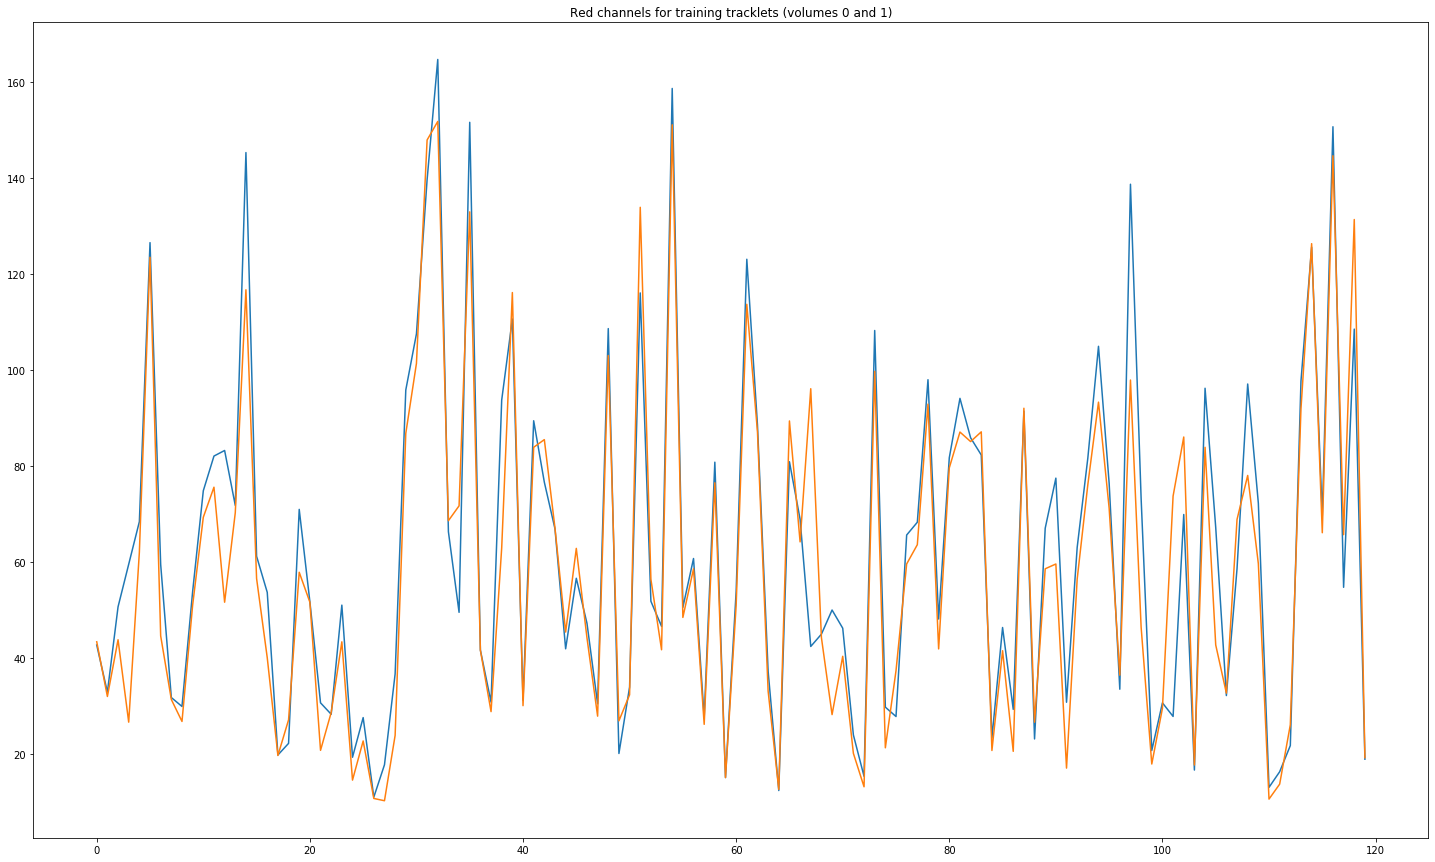

In [46]:
%matplotlib inline
plt.figure(figsize=(25,15))
plt.plot(c0[:,0])
plt.plot(c1[:,0])
plt.title("Red channels for training tracklets (volumes 0 and 1)")

In [18]:
c0[1,0], c1[1,0]

(90.7035, 41.2794)

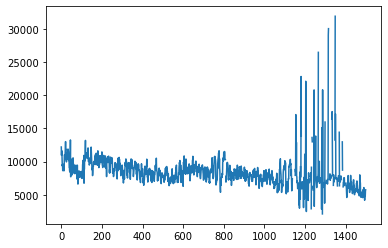

In [19]:
plt.plot(project_data.calculate_traces('red', 'integration', 'neuron_001'))

In [18]:
df_train = project_data.df_training_tracklets
# df_train

In [19]:
# list(df_train.columns.levels[0])

In [20]:
df_train['neuron10908']

coords,z,x,y,likelihood
1154,8.326415,292.669811,370.390566,0.829999
1155,7.436047,276.054264,363.397287,0.816262
1156,8.392273,251.381872,356.127786,0.861834
1157,7.773179,255.700331,364.130795,0.878108
1158,7.738579,261.145939,370.619289,0.876143
1159,7.421208,266.650957,377.534610,0.828575
1160,7.669739,276.270353,384.070661,0.878376
1161,8.014859,278.815750,386.444279,0.817545
1162,8.412518,286.972973,386.623044,0.912030
1163,8.094964,292.251799,382.037410,0.869125


In [27]:
dat0 = project_data.reindexed_metadata_training.segmentation_metadata[1154]
dat1 = project_data.reindexed_metadata_training.segmentation_metadata[1155]

i_neuron = 3

In [28]:
dat0.head()

,total_brightness,neuron_volume,centroids,all_values
10734,18757,741,"(6.532814415951378, 277.87119475395855, 492.24...","[17, 17, 19, 18, 17, 17, 17, 16, 18, 18, 20, 1..."
10909,13877,530,"(8.365929235425524, 292.71369892628087, 370.51...","[22, 20, 21, 22, 21, 19, 20, 19, 21, 24, 22, 2..."
10939,20862,780,"(7.129182245230563, 278.8900393059151, 358.470...","[21, 19, 20, 20, 21, 19, 19, 19, 20, 21, 21, 2..."
10993,22224,753,"(23.694789416846653, 271.9842512598992, 380.42...","[22, 23, 22, 23, 23, 21, 22, 23, 23, 24, 24, 2..."
11148,23138,694,"(6.1415420520356125, 283.9942950989714, 407.16...","[22, 23, 23, 24, 21, 23, 21, 25, 26, 25, 24, 2..."


In [29]:
dat1.head()

,total_brightness,neuron_volume,centroids,all_values
10734,18091,684,"(6.341937980211155, 287.74910176330775, 484.56...","[17, 18, 18, 18, 17, 19, 19, 19, 19, 20, 20, 2..."
10909,13505,516,"(7.585338763420955, 276.0966308774528, 363.489...","[19, 20, 21, 22, 19, 19, 19, 23, 22, 25, 22, 2..."
10939,16704,579,"(7.137033045977011, 259.4836566091954, 354.524...","[22, 23, 21, 21, 23, 24, 23, 23, 24, 22, 21, 2..."
10993,10006,341,"(22.973715770537677, 255.75354787127722, 374.5...","[22, 24, 26, 25, 24, 23, 27, 27, 25, 25, 24, 2..."
11148,20206,574,"(5.675195486489162, 274.5082153815698, 400.802...","[22, 21, 22, 24, 24, 22, 23, 21, 24, 26, 27, 2..."


In [32]:
all0 = dat0['all_values'].iloc[i_neuron]
all1 = dat1['all_values'].iloc[i_neuron]

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Histogram of all values from training data')

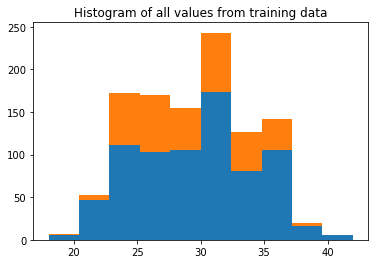

In [33]:
plt.hist([all0, all1], stacked=True)
plt.title("Histogram of all values from training data")

In [15]:
np.sum(all0), np.sum(all1)

(25205, 15318)

In [16]:
v0, v1 = dat0['neuron_volume'].iloc[i_neuron], dat1['neuron_volume'].iloc[i_neuron]
print(v0, v1)
print(np.sum(all0)/v0, np.sum(all1)/v1)

530 516
47.556603773584904 29.686046511627907


In [17]:
x0, x1 = dat0['total_brightness'].iloc[i_neuron], dat1['total_brightness'].iloc[i_neuron]
print(x0, x1)

25205 15318


In [27]:
project_data.project_config.get_training_config().config['training_data_3d']['which_frames'][0]

1154

# Look at the full metadata, not the training

In [18]:
dat0_full = project_data.segmentation_metadata.segmentation_metadata[1154]
dat1_full = project_data.segmentation_metadata.segmentation_metadata[1155]

In [19]:
target_pt = [7.6, 276, 362]
tol = 5.0

for i, row in dat0_full.iterrows():
    dist = np.linalg.norm(np.array(row['centroids']) - target_pt)
    if dist < tol:
        print(row)
        print(f"Neuron {row.name} is close to the target point")
        i_best = i


total_brightness                                                20862
neuron_volume                                                     780
centroids           (7.18974358974359, 278.87051282051283, 358.514...
all_values          [21, 19, 20, 20, 21, 19, 19, 19, 20, 21, 21, 2...
Name: 28, dtype: object
Neuron 28 is close to the target point


In [21]:
dat1_full.loc[i_best]

total_brightness                                                33101
neuron_volume                                                     944
centroids              (8.8125, 322.8135593220339, 398.2775423728813)
all_values          [24, 21, 21, 28, 25, 25, 24, 23, 20, 19, 25, 2...
Name: 28, dtype: object

In [22]:
dat0_full

,total_brightness,neuron_volume,centroids,all_values
1,52951,1475,"(5.2806779661016945, 288.3905084745763, 418.68...","[21, 19, 18, 19, 22, 23, 23, 21, 22, 20, 20, 2..."
2,20015,755,"(3.556291390728477, 304.1867549668874, 421.565...","[19, 18, 18, 18, 19, 19, 21, 19, 19, 18, 23, 2..."
3,36624,1066,"(6.107879924953096, 270.765478424015, 513.7992...","[17, 19, 19, 21, 20, 19, 18, 17, 21, 22, 26, 2..."
5,44687,1081,"(4.979648473635523, 271.104532839963, 417.1600...","[26, 25, 25, 23, 31, 31, 27, 24, 23, 30, 32, 3..."
9,8679,386,"(2.8419689119170983, 175.63989637305698, 778.9...","[17, 17, 19, 19, 16, 17, 18, 19, 20, 20, 20, 1..."
...,...,...,...,...
178,30511,1035,"(20.80289855072464, 186.6792270531401, 258.585...","[19, 18, 20, 17, 20, 23, 24, 25, 22, 21, 19, 2..."
179,8009,266,"(22.526315789473685, 230.18796992481202, 506.2...","[22, 26, 22, 21, 21, 24, 30, 32, 37, 31, 23, 3..."
180,8113,396,"(24.944444444444443, 244.55555555555554, 486.4...","[19, 20, 20, 21, 20, 19, 18, 19, 20, 20, 21, 2..."
181,12395,495,"(23.848484848484848, 216.0787878787879, 556.57...","[17, 17, 18, 18, 21, 20, 26, 27, 27, 29, 26, 2..."


# Recalculate the metadata: is Niklas' code wrong?


In [27]:
from wbfm.utils.pipeline.traces_pipeline import region_props_all_volumes, _convert_nested_dict_to_dataframe

In [47]:
project_data.which_training_frames

[1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163]

In [48]:
reindexed_masks = project_data.reindexed_masks_training
frame_list = project_data.which_training_frames
params_start_volume = 1154
coords = ['z', 'x', 'y']

lut = np.zeros(np.max(reindexed_masks)+1)
vals = np.unique(reindexed_masks)
for i, v in enumerate(vals):
    lut[v] = i


In [36]:
reindexed_masks2 = np.zeros_like(reindexed_masks)

In [38]:
num_frames = 10
for i in range(num_frames):
    reindexed_masks2[i, ...] = lut[reindexed_masks[i, ...]]
# reindexed_masks2 = lut[reindexed_masks]

In [49]:
red_all_neurons, green_all_neurons = region_props_all_volumes(
    reindexed_masks2,
    project_data.red_data,
    project_data.green_data,
    frame_list,
    params_start_volume
)

100%|███████████████████████████████████████████| 10/10 [00:09<00:00,  1.09it/s]


IndexError: index 1163 is out of bounds for axis 0 with size 10

In [60]:
df_green, df_red = _convert_nested_dict_to_dataframe(coords, frame_list, green_all_neurons, red_all_neurons)

# TODO: make sure these are strings
final_neuron_names = list(df_red.columns.levels[0])

In [61]:
df_red['neuron_002']

,area,z,x,y,intensity_image,label
1154,530.0,8.365929,292.713699,370.512575,13877.0,2.0
1155,516.0,7.585339,276.096631,363.489152,13505.0,2.0
1156,673.0,8.377027,251.466057,356.189643,17264.0,2.0
1157,604.0,7.769122,255.794342,364.197913,15623.0,2.0
1158,788.0,7.729789,261.234941,370.648844,19507.0,2.0
1159,679.0,7.511435,266.672268,377.600947,17316.0,2.0
1160,651.0,7.733587,276.283134,384.113008,17105.0,2.0
1161,673.0,8.015181,278.792851,386.515926,17456.0,2.0
1162,703.0,8.384874,286.906112,386.703883,18128.0,2.0
1163,695.0,8.167151,292.129336,382.060062,18564.0,2.0


In [55]:
# # v = napari.view_image(project_data.red_data[])
# import napari
# napari.view_labels(reindexed_masks2)

In [56]:
df_red['neuron_002']['intensity_image'] / df_red['neuron_002']['area']

1163    26.183019
1160    26.172481
1161    25.652303
1162    25.865894
1159    24.755076
1154    25.502209
1158    26.274962
1155    25.937593
1157    25.786629
1156    26.710791
dtype: float64

# Visualize matches

In [120]:
# Process into single set of matches
from scipy.optimize import linear_sum_assignment
import numpy as np
from scipy.sparse import coo_matrix

In [121]:
# Note: the second index in the match is the template
# Combine the matches from each template by summing the confidence

# First, convert each to a sparse matrix
# i_match = 0
all_final_conf = []
all_individual_conf = []
shape = (121, 121)

for i_match in range(num_templates):
    all_conf = []

    for i_template in range(num_templates):
        m = np.array(matches_per_template[i_template][i_match])
        row, col, data = m[:,0], m[:,1], m[:,2]
    #     shape = (int(max(row))+1, int(max(col))+1)
        conf = coo_matrix((data, (row, col)), shape=shape, dtype=float)
        all_conf.append(conf)
    final_conf = sum(all_conf)
    
    all_individual_conf.append(all_conf)
    all_final_conf.append(final_conf)
#     other_frame_conf = sum(all_conf[1:])


In [122]:
from ipywidgets import interact
def f(i_template=0, i_test=7):
    %matplotlib inline
    plt.figure(figsize=(25, 15))
    plt.imshow(all_individual_conf[i_test][i_template].toarray())
    plt.title("Accuracy for 1 template frame")
    plt.colorbar()
    
    plt.show()

interact(f, i_template=(0,num_templates-1), i_test=(0,num_templates-1))

interactive(children=(IntSlider(value=0, description='i_template', max=9), IntSlider(value=7, description='i_t…

<function __main__.f(i_template=0, i_test=7)>

In [123]:
from ipywidgets import interact
def f(i_test):
    %matplotlib inline
    plt.figure(figsize=(25, 15))
    plt.imshow(all_final_conf[i_test].toarray())
    plt.title("Accuracy all templates")
    plt.colorbar()
    
    plt.show()

interact(f, i_test=(0,9))

interactive(children=(IntSlider(value=4, description='i_test', max=9), Output()), _dom_classes=('widget-intera…

<function __main__.f(i_test)>

# What is the expected format for color input?

In [ ]:
template = __load_fdnc_template()

In [ ]:
template['color'].dtype